# Residential Coverage Analysis 

"""This Script uses the sample-project environment, with the osmnx module updated.
To update the osmnx module within the sample-project environment, I ran the following
conda commands in the terminal:

1)Duplicate the sample-project environment:
conda create --name sample-project_2  --clone sample-project

2)Update osmnx:
conda update osmnx

This script creates a place boundary and downloads the pois within that polygon. Next, it downloads network data:
osm edges and nodes and exports this to a geopackage.
"""

### OSMNX ISOCHRONE GUIDE
###### https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
##### UHELSKINKI AUTOGIS and Network Analysis:
###### https://autogis-site.readthedocs.io/en/latest/notebooks/L6/01_network_analysis.html
##### See Also:
###### https://pythoncharmers.com/blog/travel-distance-python-with-geopandas-folium-alphashape-osmnx-buffer.html
###### http://kuanbutts.com/2017/12/16/osmnx-isochrones/

In [1]:
import os
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import fiona
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from scipy.spatial import Voronoi
import numpy as np
import shapely

ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.2'

2021-12-25 12:24:55 Configured OSMnx 1.1.2
2021-12-25 12:24:55 HTTP response caching is on


In [2]:
from IPython.display import display

In [3]:
#For graphing features in jupyter notebook:
%matplotlib inline
# ox.config(log_console=True, use_cache=True)
# ox.__version__

In [4]:
PROJECT_FOLDER = r"/Users/calvindechicago/Documents/GitHub/JWA_2021"
COUNTY_POLYGON = os.path.join(PROJECT_FOLDER, "Data", "osm_county_polygon.gpkg" )

STUDY_AREA = "/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/route2_and_max_yellow/route2_max_yellow_buffer_poly.gpkg"
ROUTE_2_STOPS = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/Data_from_JWA/Route2_Stops.shp'
ROUTE_2_STOPS_TEST = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/route_2_stops_test/route_2_stops_test.gpkg'
MAX_YELLOW_STOPS = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/Data_from_JWA/MAX_Yellow_stops.shp'
#pois_export = os.path.join(PROJECT_FOLDER, "Data", "From_Public_Sources", "OSM_Data", "singapore_poi.shp")
pois_gpkg = os.path.join(PROJECT_FOLDER, "Data", "From_Public_Sources", "OSM", "poi.gpkg")
network_output = os.path.join(PROJECT_FOLDER, "Data", "network.gpkg")

In [5]:
# get the boundary polygon for the city or county. This polygon will be used to pull network and POIs
county_poly = ox.geocoder.geocode_to_gdf('Multnomah County')
county_proj = ox.project_gdf(county_poly,4326)

2021-12-25 12:24:58 Retrieved response from cache file "cache/8cf5ce47f3c71ddf2f130625dfbd35014712c804.json"
2021-12-25 12:24:58 Created GeoDataFrame with 1 rows from 1 queries
2021-12-25 12:24:58 Projected GeoDataFrame to 4326


<AxesSubplot:>

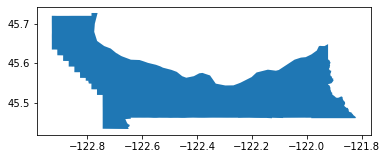

In [6]:
# Plot County geometry
county_proj.plot()

In [ ]:
# Export County Geometry

county_proj.to_file(COUNTY_POLYGON, layer='county_poly', driver="GPKG")

In [7]:
# Use this polygon to pull network in osmnx

polygon = county_proj['geometry'].iloc[0]

In [8]:
# PULL NETWORK
# NOTE: Setting network type is important, and analysis on the network failed when I did not set the network type. 

network_type='walk'

G = ox.graph_from_polygon(polygon,  network_type=network_type)

# print('Making the graph undirected')
# G = G.to_undirected()


2021-12-25 12:25:26 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-25 12:25:26 Projected GeoDataFrame to epsg:4326
2021-12-25 12:25:26 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-25 12:25:27 Projected GeoDataFrame to epsg:4326
2021-12-25 12:25:27 Requesting data within polygon from API in 1 request(s)
2021-12-25 12:25:28 Retrieved response from cache file "cache/1540e6335ee5fbc9efcce76059b6fd0d604fa035.json"
2021-12-25 12:25:28 Got all network data within polygon from API in 1 request(s)
2021-12-25 12:25:28 Creating graph from downloaded OSM data...
2021-12-25 12:25:37 Created graph with 385673 nodes and 841414 edges
2021-12-25 12:25:43 Added length attributes to graph edges
2021-12-25 12:25:43 Identifying all nodes that lie outside the polygon...
2021-12-25 12:26:02 Created nodes GeoDataFrame from graph
2021-12-25 12:26:16 Created r-tree spatial index for 385673 g

In [9]:
# Project the graph to UTM 
# osmnx automatically determines correct UTM zone and projects the graph. 
# Unit: Meters

G = ox.project_graph(G)


2021-12-25 12:34:40 Created nodes GeoDataFrame from graph
2021-12-25 12:34:49 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-25 12:35:06 Created edges GeoDataFrame from graph
2021-12-25 12:35:17 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-25 12:35:24 Created graph from node/edge GeoDataFrames
2021-12-25 12:35:24 Projected graph with 80407 nodes and 228468 edges


2021-12-25 12:36:03 Begin plotting the graph...
2021-12-25 12:36:11 Created edges GeoDataFrame from graph
2021-12-25 12:36:21 Created nodes GeoDataFrame from graph


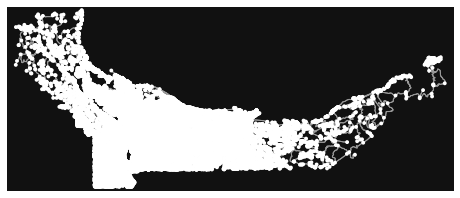

2021-12-25 12:36:36 Finished plotting the graph


In [10]:

fig, ax = ox.plot_graph(G)

In [12]:
# Set travel speed and desired isochrone radius 

travel_speed = 4.5  # walking speed in km/hour (about 2.8 mph)
miles = .5


In [13]:
# Add an edge attribute for time in minutes required to traverse each edge

# For more info on networkx and graph.edges function used here, see:
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute




In [14]:
# - Simple conversion function that determines the travel time 
# needed to travel a given distance in (Miles) at a given speed (in KPH). 
# - It takes as inputs a distance (in Miles) and travel speed (KPH)
# - The distance provided sets the network based travel radius to create isochrones. 
# - The travel speed given approximates the speed of a given mode, such as bicycling, walking, or transit. 
# - The trip time produced is appended to an empty list to work with
# the isochrone creation script written by Geoff Boeing. 


def kph_dist_calc(travel_speed, miles):
    dist_kilometers = miles * 1.60934
    trip_time = []
    trip_time.append((dist_kilometers / travel_speed)*60)
    return(trip_time)
    

# Run function with inputs defined in earlier cell    
trip_time = kph_dist_calc(travel_speed, miles)



In [20]:
# Future functions require the trip time value be numeric, not a list. 

trip_time = trip_time[0]
trip_time

10.728933333333334

In [15]:
# Create Geodataframe from graph edges to view data

gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

2021-12-25 12:41:12 Created edges GeoDataFrame from graph
2021-12-25 12:41:15 Created nodes GeoDataFrame from graph


In [17]:
gdf_edges.crs

<Derived Projected CRS: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# Geopackage does not accept columns with lists as values. Iterate over invalid columns and convert to strings:
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid', 'highway', 'est_width', 'service', 'access', 
               'bridge', 'ref','tunnel', 'junction', 'landuse', 'width', 'area']
for col in invalid_cols:
    gdf_edges[col] = gdf_edges[col].astype(str)

In [19]:
#EXPORT EDGES to GEOPACKAGE

gdf_edges_filepath ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/edges.gpkg"
gdf_edges.to_file(gdf_edges_filepath, layer='edges', driver="GPKG")

In [21]:
# Read in Bus Stops to geodataframe

route_2_stops = gpd.read_file(ROUTE_2_STOPS)
max_yellow_stops = gpd.read_file(MAX_YELLOW_STOPS)

#ROUTE_2_STOPS_TEST = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/route_2_stops_test/route_2_stops_test.gpkg'
#ROUTE_2_STOPS_TEST = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/route_2_stops_test/route_2_stops_test_v2.gpkg'


#route_2_stops = gpd.read_file(ROUTE_2_STOPS_TEST, layer='route_2_stops_test')
#route_2_stops = gpd.read_file(ROUTE_2_STOPS_TEST, layer='route_2_stops_test_v2')



In [22]:
all_stops = route_2_stops.append(max_yellow_stops)

<AxesSubplot:>

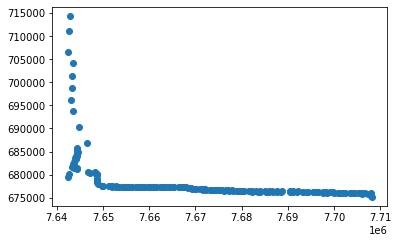

In [23]:
all_stops.plot()

In [24]:
all_stops.crs

<Derived Projected CRS: EPSG:2269>
Name: NAD83 / Oregon North (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (International feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [25]:
# Project route_2_stops to UTM CRS of graph
all_stops = all_stops.to_crs(epsg=32610)



In [37]:
# Export the merged all stops 

all_stops_file ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/all_stops.gpkg"
all_stops.to_file(all_stops_file, layer='all_stops', driver="GPKG")

In [26]:
#nearest_nodes = []
nearest_node = ox.distance.nearest_nodes(G, all_stops['geometry'].x, all_stops['geometry'].y )
#nearest_nodes.append(nearest_node)

print("The nearest nodes are: \n ")
nearest_node

2021-12-25 12:56:12 Created nodes GeoDataFrame from graph
The nearest nodes are: 
 


[8530056035,
 1392895123,
 1525729024,
 333332728,
 40602211,
 1601885117,
 40692280,
 40536806,
 1387003072,
 1386993937,
 1386994338,
 7979194296,
 1451089540,
 333465373,
 4582091925,
 8383153041,
 40469244,
 1568023487,
 40732679,
 40419039,
 4580524805,
 40607516,
 7520853998,
 8315226142,
 40637562,
 40627252,
 40723551,
 40657510,
 4581700183,
 40675592,
 40446196,
 4582099930,
 4582099930,
 4578417041,
 4581947135,
 40603741,
 40583575,
 40583575,
 8508594053,
 40393454,
 5980806592,
 4691595334,
 8488999004,
 5311230286,
 40689628,
 40669850,
 1486833614,
 40689628,
 40498312,
 8386372003,
 5735128648,
 1831522747,
 1368361293,
 40703351,
 40703351,
 40562035,
 4581775926,
 40534536,
 4581758291,
 4086104973,
 7010735905,
 4086104902,
 8694846749,
 9338370475,
 40719837,
 40524665,
 4580531712,
 40524665,
 4042040839,
 7765373708,
 4580531708,
 40628183,
 4580531788,
 1576367469,
 4210464332,
 40479423,
 40621545,
 4195841447,
 40479423,
 1319666175,
 4195841449,
 40524522,
 4

In [ ]:
# Test on single node

# node1 = nearest_node[0]
# subgraph = nx.ego_graph(G, node1, radius=trip_time, distance='time')
# node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
# node_points

In [27]:
# Make ISOCHRONES for each Bus Stop
isochrone_polys = []
for node in nearest_node:
    # make the isochrone polygons
    subgraph = nx.ego_graph(G, node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

len(node_points)

In [29]:
#Create geodataframe of isochrones for export

isochrone_gdf = gpd.GeoDataFrame(isochrone_polys, geometry=0)

In [31]:
#SET CRS
isochrone_gdf = isochrone_gdf.set_crs(epsg=32610)

In [32]:
# Export Isochrone layer

isochrone_export_3="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/isochrones/all_stops_iso.gpkg"

isochrone_gdf.to_file(isochrone_export_3, layer='all_stops_iso', driver="GPKG")

In [34]:
# Dissolve the Isochrones
# Geopandas requires a dissolve field. Create new field and set every row to 1. 

isochrone_gdf['dissolvefield']= 1
iso_dissolved = isochrone_gdf.dissolve(by='dissolvefield')


In [36]:
#SET CRS
iso_dissolved = iso_dissolved.set_crs(epsg=32610)

# Export Isochrone layer

isochrone_export_3="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/isochrones/all_stops_iso.gpkg"

iso_dissolved.to_file(isochrone_export_3, layer='isos_dissolved', driver="GPKG")


In [38]:
# Create point data from all bus stop points
# This is a necessary step to using the Shapely Voronoi tool

all_stops_points = all_stops['geometry']

In [39]:
# Create array of coordinates for all stops

x = all_stops.geometry.x.values
y = all_stops.geometry.y.values
coords = np.vstack((x, y)).T



In [40]:
# The shapely Voronoi tool has an issue with creating polygons for some outlying points. 
# See Stackoverflow for notes:
# # FROM: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

# To work around the issue create the vertices for an enlarged bounding box. 
# This isn't a perfect solution, but should work well enough for this application. 
# Here I use +/- 5000 meters. 

def enlarged_bbox(points):
    x_coordinates, y_coordinates = zip(*points)

    return [(min(x_coordinates)-5000,min(y_coordinates)-5000), (max(x_coordinates)+5000, max(y_coordinates)+5000), 
            (min(x_coordinates)-5000, max(y_coordinates)+5000 ), (max(x_coordinates)+5000, min(y_coordinates)-5000)]



In [41]:
# Run enlarged_bbox function

bbox = enlarged_bbox(coords)

In [42]:
# Put enlarged bbox in Geodataframe. This creates a geodataframe with two columns:
# one with x coordinates and another with y coordinates. 
gdf_bbox = gpd.GeoDataFrame(bbox)

# Create a single column geodataframe with a geometry column with the enlarged bbox coordinates
bbox_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(gdf_bbox[0], gdf_bbox[1]))

# View results
bbox_gdf

,geometry
0,POINT (519502.724 5033943.933)
1,POINT (549804.882 5055259.285)
2,POINT (519502.724 5055259.285)
3,POINT (549804.882 5033943.933)


In [43]:
# Append enlarged bbox vertices to points

print('Coords shape before adding enlarged bounding box vertices:\n')
print(coords.shape)

coords = np.append(coords, bbox_coords, axis = 0)

print('Coords shape after adding enlarged bounding box vertices:\n')
print(coords.shape)

Coords shape before adding enlarged bounding box vertices:

(178, 2)


NameError: name 'bbox_coords' is not defined

In [ ]:
# Set CRS and Export
bbox_gdf = bbox_gdf.set_crs(epsg=32610)
enlarged_bbox_file ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/enlarged_bbox.gpkg"
bbox_gdf.to_file(enlarged_bbox_file, layer='enlarged_bbox', driver="GPKG")

In [ ]:
# Previous code - Saving here as notes
# gdf_bbox = gpd.points_from_xy(gdf_bbox[0], gdf_bbox[1])
# bbox_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(gdf_bbox.x, gdf_bbox.y))

In [ ]:
# Run Shapely voronoi tool on original points, with enlarged bounding box vertices added to point list
vor = Voronoi(coords)

In [ ]:
# Create polygons from Shapely Voronoi data 

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]
polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys))
lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
regions = gpd.GeoDataFrame(data=shapely.ops.polygonize(lines), columns=['geometry'], geometry='geometry')



In [ ]:
# Project and Export newly created voronoi polygons
regions = regions.set_crs(epsg=32610)

# Save Voronoi Polygons to disk
regions_file ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/voronois.gpkg"
regions.to_file(regions_file, layer='voronois', driver="GPKG")

In [ ]:
# TO DO: 
# 1 DONE join block group pop totals with block group geographies and export
# 2 DONE Make 1/2 mile isochrones for each transit stop and export
# 3 DONE Merge Isochrones
# 4 Create Voronoi Polygons within merged isochrones
# 5 Where Voronoi Polygons overlap multiple blockgroups, find proportion that they overlap and calculate proportional total population.
# 6 join Voronoi Stats with each Stop
# Create Leaflet Layer for Voronoi Polygons and symbolize graduated on ridership capture areas to show high/low areas. 

# TO DO:
# iterate through bus stop list and find nearest node
# Creates 1/2 mile isochrone for each bus stop nearest node. 